## Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive/ML/

Test.csv  Train.csv  Valid.csv


In [ ]:
# Read dataset
train_df = pd.read_csv("gdrive/MyDrive/ML/Train.csv")

In [ ]:
# first few lines
train_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
# shape of dataset
train_df.shape

(40000, 2)

Let's see weather our dataset is balanced or imbalanced

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


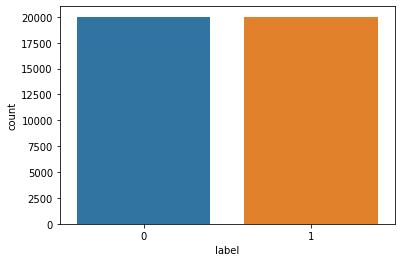

In [ ]:
sns.countplot(train_df['label'])

From above graph we can see that our dataset is balanced dataset.So that's great

## Tokenization

**Tokenization** is the process of tokenizing or splitting a string, text into a list of tokens.  

In [ ]:
train_df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in train_df['text']]

## Stemming

**Stemming** is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.The input to the stemmer is tokenized words.
A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate”   

In [ ]:
porter_stemmer = PorterStemmer()
train_df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in train_df['tokenized_text']]
train_df

,text,label,tokenized_text,stemmed_tokens
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, up, watching, and, loving, the, thunder...","[grew, up, watch, and, love, the, thunderbird,..."
1,"When I put this movie in my DVD player, and sa...",0,"[when, put, this, movie, in, my, dvd, player, ...","[when, put, thi, movi, in, my, dvd, player, an..."
2,Why do people who do not know what a particula...,0,"[why, do, people, who, do, not, know, what, pa...","[why, do, peopl, who, do, not, know, what, par..."
3,Even though I have great interest in Biblical ...,0,"[even, though, have, great, interest, in, bibl...","[even, though, have, great, interest, in, bibl..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dads, army, fan, and, nothing,...","[im, die, hard, dad, armi, fan, and, noth, wil..."
...,...,...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1,"[western, union, is, something, of, forgotten,...","[western, union, is, someth, of, forgotten, cl..."
39996,This movie is an incredible piece of work. It ...,1,"[this, movie, is, an, incredible, piece, of, w...","[thi, movi, is, an, incred, piec, of, work, it..."
39997,My wife and I watched this movie because we pl...,0,"[my, wife, and, watched, this, movie, because,...","[my, wife, and, watch, thi, movi, becaus, we, ..."
39998,"When I first watched Flatliners, I was amazed....",1,"[when, first, watched, flatliners, was, amazed...","[when, first, watch, flatlin, wa, amaz, it, ha..."


## Train-Test Split

In [ ]:

# Train Test Split Function
def split_train_test(train_df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(train_df[['stemmed_tokens']], 
                                                        train_df['label'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(train_df)

Value counts for Train sentiments
1    14002
0    13998
Name: label, dtype: int64
Value counts for Test sentiments
0    6021
1    5979
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                     stemmed_tokens
0  30925  [even, though, thi, movi, came, out, year, bef...
1  32794  [saw, the, film, yesterdai, and, realli, enjoi...
2  26673  [see, that, thoma, howel, ha, appear, in, mani...
3   5114  [want, to, like, thi, movi, realli, realli, di...
4  31977  [after, view, sever, episod, of, thi, seri, ha...


## Word2Vec Model Creation

**word2vec** algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. 

In [ ]:
size = 500
window = 3
min_count = 1
workers = 3
# 0 for CBOW, 1 for skip-gram
sg = 0
OUTPUT_FOLDER = '/kaggle/working/'
# Function to train word2vec model
def make_word2vec_model(train_df, padding, sg, min_count, size, workers, window):
    if  padding:
        #print(len(train))
        temp_df = pd.Series(train_df['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        #print(str(size))
        word2vec_file = OUTPUT_FOLDER + '2ata' + '_PAD.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    #w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(train_df, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

FileNotFoundError: ignored

## Padding

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.
**Padding** will make all sentences of same length by inserting 0 in the end or bigenning of the sentences

In [ ]:
max_sen_len = train_df.stemmed_tokens.map(len).max()

padding_idx = w2vmodel.wv.vocab['pad'].index
print(padding_idx)
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

2967


In [ ]:
max_sen_len

2380

In [ ]:
padding_idx

2967

## CNN model 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10

#torch.nn.Conv2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], 
#stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, 
#dilation: Union[T, Tuple[T, T]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + '2ata_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        # like a python list, it was designed to store any desired number of nn.Module
        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])
    
        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [ ]:
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)

## Train the model

In [ ]:
NUM_CLASSES = 2
VOCAB_SIZE = len(w2vmodel.wv.vocab)
print(VOCAB_SIZE)
cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)
num_epochs = 5

62518


In [ ]:
# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER + '1cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []

cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0

    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        #print(Y_train['label'][index])
        target = make_target(Y_train['label'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()
        

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

    print(f'train_loss : {train_loss / len(X_train)}')
    print("Epoch ran :"+ str(epoch+1))
    
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
train_loss : 0.5036109324991703
Epoch ran :1
Epoch2
train_loss : 0.43828793318782533
Epoch ran :2
Epoch3
train_loss : 0.4216930166397776
Epoch ran :3
Epoch4
train_loss : 0.4101412386149168
Epoch ran :4
Epoch5
train_loss : 0.39909448505512307
Epoch ran :5
Input vector
Probs
tensor([[0.0144, 0.9856]], device='cuda:0', grad_fn=<SoftmaxBackward>)
1


## Model Test

Index(['iter', ' loss'], dtype='object')
[[5404  617]
 [ 828 5151]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6021
           1       0.89      0.86      0.88      5979

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000

Index(['iter', ' loss'], dtype='object')


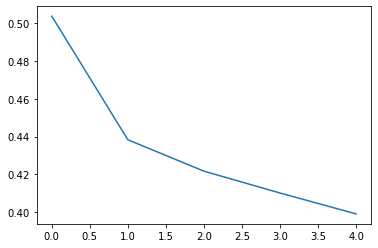

In [ ]:
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '1cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')

y_pred_list = []
y_true_list = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        #print(row['stemmed_tokens'])
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        #print(bow_vec)
        probs = cnn_model(bow_vec)
        #print(probs.data)
        _, predicted = torch.max(probs.data,  1)
        
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['label'][index]).cpu().numpy()[0])

print(confusion_matrix(original_lables_cnn_bow, bow_cnn_predictions))
#print(original_lables_cnn_bow)
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER + '1cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER + '1loss_plt_500_padding_30_epochs.pdf')